# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Data Engineering and Machine Learning Operations in Business** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## <span style='color:#2656a3'> 🗒️ This notebook is divided into the following sections:

1. Load batch data.
2. Predict using model from Model Registry.

## <span style='color:#2656a3'> ⚙️ Import of libraries and packages

First, we'll install the Python packages required for this notebook. We'll use the --quiet command after specifying the names of the libraries to ensure a silent installation process. Then, we'll proceed to import all the necessary libraries.

In [1]:
# First we go one back in our directory to access the folder with our functions
%cd ..

# Now we import the functions from the features folder
# This is the functions we have created to generate features for electricity prices and weather measures
from features import electricity_prices, weather_measures, calendar 

# We go back into the notebooks folder
%cd notebooks

/Users/tobiasmjensen/Documents/aau_bds/m5_data-engineering-and-mlops/exam_assigment/MLOPs-Assignment-
/Users/tobiasmjensen/Documents/aau_bds/m5_data-engineering-and-mlops/exam_assigment/MLOPs-Assignment-/notebooks


In [2]:
# Importing the packages for the needed libraries for the Jupyter notebook
import joblib
import inspect 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os

#%config InlineBackend.figure_format='retina'
#%matplotlib inline

## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store

In [3]:
# Importing the hopsworks module
import hopsworks

# Logging in to the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/554133
Connected. Call `.close()` to terminate connection gracefully.


### <span style='color:#2656a3'> ⚙️ Feature View Retrieval

In [4]:
# Retrieve the 'electricity_training_feature_view' feature view
feature_view_training = fs.get_feature_view(
    name='electricity_training_feature_view',
    version=1,
)

### <span style='color:#2656a3'> 🗄 Model Registry

In [5]:
# Retrieve the model registry
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


## <span style='color:#2656a3'> 📮 Retrieving model from Model Registry

In [6]:
# Retrieving the model from the Model Registry
retrieved_model = mr.get_model(
    name="electricity_price_prediction_model", 
    version=1,
)

# Downloading the saved model to a local directory
saved_model_dir = retrieved_model.download()

# Loading the saved XGB model
retrieved_xgboost_model = joblib.load(saved_model_dir + "/dk_electricity_model.pkl")

In [7]:
# Display the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style='color:#2656a3'> ✨ Load New Data

In [8]:
# Fetching weather forecast measures for the next 5 days
weather_forecast_df = weather_measures.forecast_weather_measures(
    forecast_length=5
)

# Fetching danish calendar
calendar_df = calendar.dk_calendar()

# Merging the weather forecast and calendar dataframes
new_data = pd.merge(weather_forecast_df, calendar_df, how='inner', left_on='date', right_on='date')

# Displaying the new data
new_data.tail()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,timestamp,datetime,date,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
115,1715108400000,2024-05-07 19:00:00,2024-05-07,19,12.0,41.0,0.0,0.0,0.0,0.0,0.0,4.2,10.8,1,7,5,2024,1
116,1715112000000,2024-05-07 20:00:00,2024-05-07,20,10.7,49.0,0.0,0.0,0.0,0.0,0.0,3.6,8.3,1,7,5,2024,1
117,1715115600000,2024-05-07 21:00:00,2024-05-07,21,9.6,56.0,0.0,0.0,0.0,0.0,0.0,3.2,5.4,1,7,5,2024,1
118,1715119200000,2024-05-07 22:00:00,2024-05-07,22,8.7,58.0,0.0,0.0,0.0,0.0,0.0,3.3,5.8,1,7,5,2024,1
119,1715122800000,2024-05-07 23:00:00,2024-05-07,23,7.9,57.0,0.0,0.0,0.0,0.0,0.0,3.8,6.5,1,7,5,2024,1


In [9]:
# Drop columns 'date', 'datetime', 'timestamp' from the DataFrame 'new_data'
data = new_data.drop(columns=['date', 'datetime', 'timestamp'])

# Displaying the last 5 rows of the modified DataFrame
data.tail()

,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
115,19,12.0,41.0,0.0,0.0,0.0,0.0,0.0,4.2,10.8,1,7,5,2024,1
116,20,10.7,49.0,0.0,0.0,0.0,0.0,0.0,3.6,8.3,1,7,5,2024,1
117,21,9.6,56.0,0.0,0.0,0.0,0.0,0.0,3.2,5.4,1,7,5,2024,1
118,22,8.7,58.0,0.0,0.0,0.0,0.0,0.0,3.3,5.8,1,7,5,2024,1
119,23,7.9,57.0,0.0,0.0,0.0,0.0,0.0,3.8,6.5,1,7,5,2024,1


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [10]:
# Make predictions on the batch data using the retrieved XGBoost regressor model
predictions = retrieved_xgboost_model.predict(data)

See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


In [11]:
# Make predictions on the new data using the retrieved XGBoost regressor model
predictions_data = {
    'prediction': predictions,
    'time': new_data["datetime"],
}

# Create a DataFrame from the predictions data
predictions_df = pd.DataFrame(predictions_data)

# Display the predictions
predictions_df

,prediction,time
0,0.260812,2024-05-03 00:00:00
1,0.168374,2024-05-03 01:00:00
2,0.248562,2024-05-03 02:00:00
3,0.308215,2024-05-03 03:00:00
4,0.273427,2024-05-03 04:00:00
...,...,...
115,0.821896,2024-05-07 19:00:00
116,0.896060,2024-05-07 20:00:00
117,0.718041,2024-05-07 21:00:00
118,0.637762,2024-05-07 22:00:00


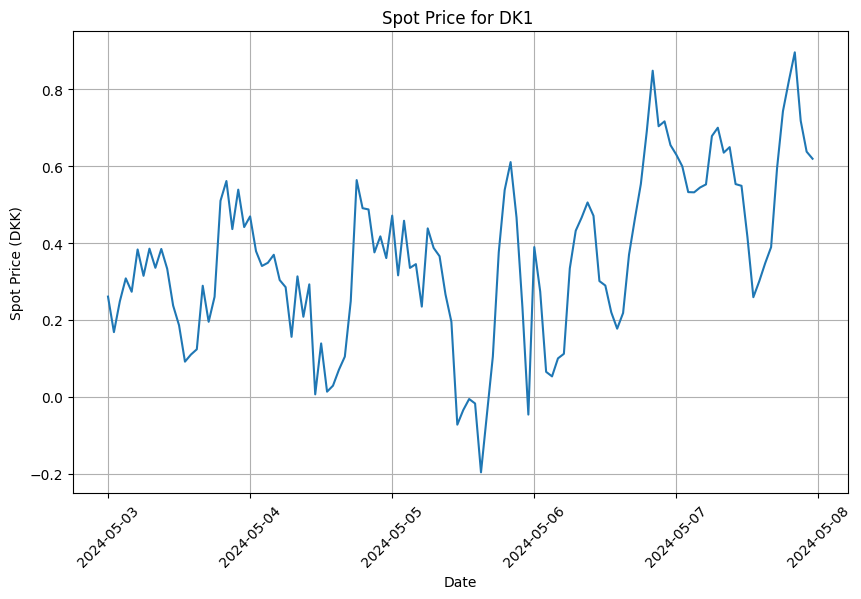

In [12]:
import matplotlib.pyplot as plt
 
# Group the data by date and calculate the average temperature for each day
daily_data = predictions_df.groupby('time')['prediction'].mean()
 
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(daily_data.index, daily_data.values)
plt.xlabel('Date')
plt.ylabel('Spot Price (DKK)')
plt.title('Spot Price for DK1 ')
plt.xticks(rotation=45)
plt.grid(True)
 
# Show the plot
plt.show()

In [13]:
import pandas as pd
import altair as alt
 
# Create Altair chart with line and dots
chart = alt.Chart(predictions_df).mark_line(point=True).encode(
    x='time:T',
    y='prediction:Q',
    tooltip=[alt.Tooltip('time:T', title='Date', format='%Y-%m-%d'), 
             alt.Tooltip('time:T', title='Time', format='%H:%M'), 
             alt.Tooltip('prediction:Q', title='Spot Price (DKK)', format='.2f')
            ]
)
 
# Display the chart
chart.interactive()

alt.Chart(...)

---
## <span style="color:#ff5f27;">👾 Next is creating our Streamlit App</span>